In [1]:
from bw_recipe_2016 import (
    FossilResourceScarcity,
    get_biosphere_database, 
    extract_recipe,
)

In [2]:
data = extract_recipe()[20]

In [3]:
biosphere = get_biosphere_database()

In [5]:
sorted([x for x in biosphere if x['categories'][0] == 'natural resource'], key=lambda x: x['name'])

['Actinium, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Aluminium, 24% in bauxite, 11% in crude ore, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Aluminium, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Anhydrite, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Antimony, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Argon-40' (kilogram, None, ('natural resource', 'in air')),
 'Arsenic, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Astatine, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Barite, 15% in crude ore, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Barium, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Basalt, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Beryllium, in ground' (kilogram, None, ('natural resource', 'in ground')),
 'Bismuth, in ground' (kilogram, None, ('natural reso

In [4]:
gw = FossilResourceScarcity(data, biosphere)

In [5]:
gw.apply_strategies()

Applying strategy: fix_perspective_string
Applying strategy: generic_reformat
Applying strategy: split_synonyms
Applying strategy: more_synonyms
Applying strategy: fix_unit_string
Applying strategy: name_matcher
Applying strategy: fossil_method_name
Applying strategy: add_fossil_natural_resource_category
Applying strategy: match_multiple
Applied 9 strategies in 0.01 seconds


In [6]:
gw.write_excel("fossil_resource_scarcity")

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/default.c21f969b/output/lcia-matching-fossil_resource_scarcity.xlsx


In [7]:
gw.statistics()

1 methods
5 cfs
0 unlinked cfs


(1, 5, 0)

In [8]:
comp = gw.compare_to_previous()

In [9]:
[(key, len(comp[key])) for key in comp]

[('found', 5), ('missing', 0), ('reference', 5)]

Present in previous ReCiPe, missing here

In [10]:
sorted(comp['reference'].difference(comp['found']))

['gas, mine, off-gas, process, coal mining']

In [11]:
gw.write_methods(overwrite=True)

Wrote 1 LCIA methods with 5 characterization factors


In [13]:
gw.data[0]['name']

('ReCiPe 2016', 'v1.1 (20180117)', 'Fossil resource scarcity')

# Compare to previous ReCiPe method

In [14]:
%matplotlib inline

In [15]:
import bw2data, bw2calc
import pyprind
import seaborn as sb
import numpy as np

In [16]:
keys = sorted([x.key for x in bw2data.Database("ecoinvent 3.6 cutoff")])

In [17]:
results_reference, results_2016 = [], []

In [18]:
lca = bw2calc.LCA({keys[0]: 1}, gw.previous_reference)
lca.lci()
lca.lcia()

In [19]:
reference_cm = lca.characterization_matrix.copy()

In [20]:
lca.switch_method(('ReCiPe 2016', 'v1.1 (20180117)', 'Fossil resource scarcity'))

In [21]:
lca.characterization_matrix.sum(), reference_cm.sum()

(2.6999999582767487, 3.8790000081062317)

In [22]:
new_cm = lca.characterization_matrix.copy()

In [23]:
for key in pyprind.prog_bar(keys):
    lca.redo_lci({key: 1})
    results_reference.append((reference_cm * lca.inventory).sum())
    results_2016.append((new_cm * lca.inventory).sum())    

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:24


/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


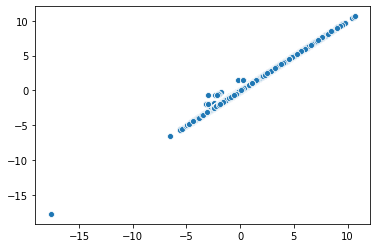

In [24]:
sb.scatterplot(np.log10(np.array(results_reference)), np.log10(np.array(results_2016)))

In [26]:
def masked_ratio(a, b):
    a, b = np.array(a), np.array(b)
    mask = (a != 0) * (b != 0)
    return a / b

/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


OverflowError: cannot convert float infinity to integer

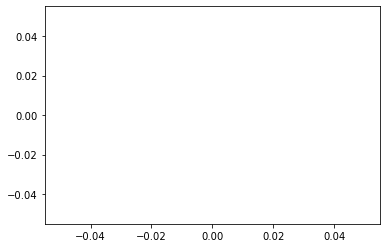

In [23]:
sb.distplot(masked_ratio(results_2016, results_reference))

In [24]:
def abnormal_ratio(a, b):
    if not a or not b:
        return
    ratio = abs(a / b)
    if 0.8 < ratio < 1.25:
        return
    return ratio

In [ ]:
exceptions = sorted([
    (abnormal_ratio(results_2016[i], results_reference[i]), bw2data.get_activity(key)) 
    for i, key in enumerate(keys) 
    if abnormal_ratio(results_2016[i], results_reference[i])
], reverse=True)

In [ ]:
len(exceptions)

In [ ]:
exceptions[:10]

In [ ]:
lca.redo_lci({exceptions[0][1]: 1})
lca.characterized_inventory = new_cm * lca.inventory